In [29]:
% t_colorGaborScene
%
% Create a scene with a color gabor patch with color directions
% specified as L, M, and S cone contrasts.  The scene will produce
% a Gabor with these contrasts on a specified monitor.

In [30]:
%% Clear
ieInit; clear; close all;

In [31]:
%% Define parameters of a gabor pattern
%
% Parameters in degrees.  The field of view is the horizontal dimension.
fieldOfViewDegs = 4;
cyclesPerDegree = 2;
gaussianFWHMDegs = 1.5;

% Convert to image based parameterss for call into pattern generating routine.
cyclesPerImage = fieldOfViewDegs*cyclesPerDegree;
gaussianStdDegs = FWHMToStd(1.5);
gaussianStdImageFraction = gaussianStdDegs/fieldOfViewDegs;

% Parameters for a full contrast vertical gabor centered on the image
parms.row = 128;
parms.col = 128;
parms.freq = cyclesPerImage;
parms.contrast = 1;
parms.ang = 0;
parms.ph = 0;
parms.GaborFlag = gaussianStdImageFraction;

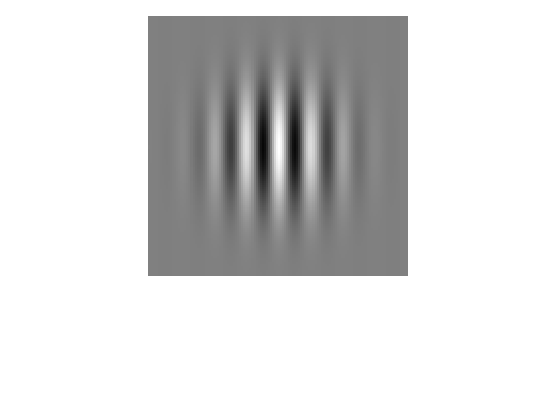

In [32]:
%% Make the gabor pattern and have a look at the grayscale image
%
% We can see it as a grayscale image
gaborPattern = imageHarmonic(parms);
vcNewGraphWin; imshow(gaborPattern/max(gaborPattern(:))); colormap(gray); axis square;

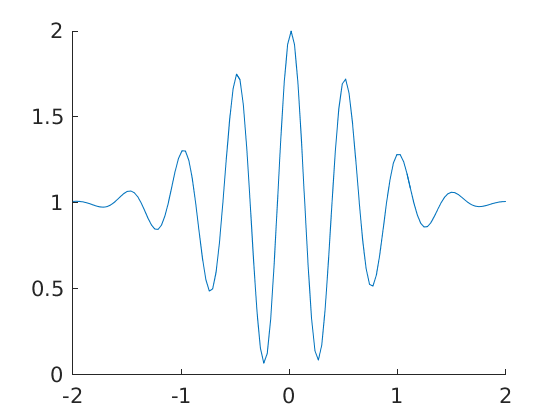

In [33]:
%% Plot a slice through the gabor's center.
%
% This is useful for verifying that the spatial parameters produce the desired
% result in degrees.  If you generate the Gabor for 0 cpd you can see the Gaussian
% profile and verify that the FWHM is in fact the specified number of
% degrees, and if you make the Gaussian window wide you can count cycles
% and make sure they come out right as well.
figure; hold on;
xDegs = linspace(-fieldOfViewDegs/2,fieldOfViewDegs/2,parms.col);
plot(xDegs,gaborPattern(parms.row/2,:));

In [34]:
%% Convert the Gabor pattern to a modulation around the mean
%
% This is easy, because imageHarmoic generates the Gabor as a modulation
% around 1.  Subtracting 1 gives us a modulation in the range -1 to 1.
gaborModulation = gaborPattern-1;

%% Convert Gabor to a color modulation specified in cone space
%
% This requires a little colorimetry.

% Specify L, M, S cone contrasts for the modulation
testConeContrasts = [0.05 -0.05 0]';

% Specify xyY (Y in cd/m2) coordinates of background (because this is what is often
% done in papers.  This is a slighly bluish background, as was used by
% Poirson & Wandell (1996).
backgroundxyY = [0.27 0.30 49.8]';

% Need to load cone fundamentals and XYZ color matching functions to do the
% needed conversions.  Here we'll use the Stockman-Sharpe 2-degree
% fundamentals and the proposed CIE corresponding XYZ functions.  These
% have the advantage that they are an exact linear transformation away from
% one another.
%
% This is the PTB style data, which I know like the back of my hand.  There
% is an isetbio way to do this too, I'm sure.  The factor of 683 in front
% of the XYZ color matching functions brings the luminance units into cd/m2
% when radiance is in Watts/[m2-sr-nm], which are fairly standard units.
whichXYZ = 'xyzCIEPhys2';
theXYZ = load(['T_' whichXYZ]);
eval(['T_XYZ = 683*theXYZ.T_' whichXYZ ';']);
eval(['S_XYZ = theXYZ.S_' whichXYZ ';']);
clear theXYZ

whichCones = 'cones_ss2';
theCones = load(['T_' whichCones]);
eval(['T_cones = 683*theCones.T_' whichCones ';']);
eval(['S_cones = theCones.S_' whichCones ';']);
clear theCones

% Tranform background into cone excitation coordinates. I always like to
% check with a little plot that I didn't bungle the regression.
M_XYZToCones = ((T_XYZ')\(T_cones'))';
T_conesCheck = M_XYZToCones*T_XYZ;
if (max(abs(T_conesCheck(:)-T_cones(:))) > 1e-3)
    error('Cone fundamentals are not a close linear transform of XYZ CMFs');
end

% Convert background to cone excitations
backgroundConeExcitations = M_XYZToCones*xyYToXYZ(backgroundxyY);

% Convert test cone contrasts to cone excitations
testConeExcitations = (testConeContrasts .* backgroundConeExcitations);

% Make the color gabor in LMS excitations
gaborConeExcitationsBg = ones(parms.row,parms.col);
gaborConeExcitations = zeros(parms.row,parms.col,3);
for ii = 1:3
    gaborConeExcitations(:,:,ii) = gaborConeExcitationsBg*backgroundConeExcitations(ii) + ...
        gaborModulation*testConeExcitations(ii);
end

% Check that contrasts come out right.  They will be a little
% less than nominal values becuase it's a Gabor, not a sinusoid.
coneTypes = {'L' 'M' 'S'};
for ii = 1:3
    gaborPlane = gaborConeExcitations(:,:,ii);
    theMax = max(gaborPlane(:)); theMin = min(gaborPlane(:));
    actualConeContrasts(ii) = (theMax-theMin)/(theMax+theMin);
    fprintf('Actual absolute %s cone contrast: %0.3f, nominal: % 0.3f\n', coneTypes{ii}, ...
        actualConeContrasts(ii),abs(testConeContrasts(ii)));
end

Actual absolute L cone contrast: 0.048, nominal:  0.050
Actual absolute M cone contrast: 0.048, nominal:  0.050
Actual absolute S cone contrast: 0.000, nominal:  0.000


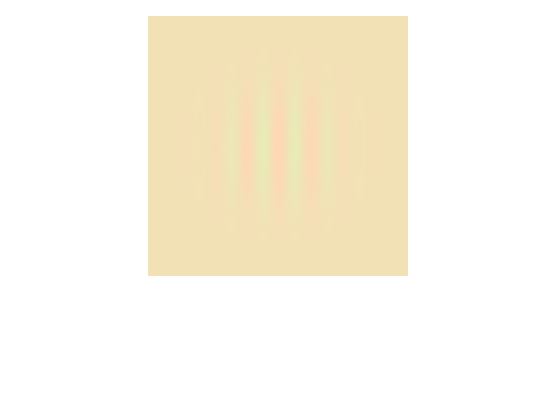

In [35]:
%% And take a look at the LMS image.  This is just a straight rendering of
% LMS and so won't look the right colors, but we can check that it is
% qualitatively correct.
vcNewGraphWin; imshow(gaborConeExcitations/max(gaborConeExcitations(:)));

In [36]:
%% Produce an isetbio scene
%
% This should represent a monitor image that produces the desired LMS
% excitations.

% We need a display.  We'll just use the description of a CRT that we have
% handy.  In doing so, we are assuming that the differences between CRT's
% used in different threshold experiments do not have a substantial effect
% on the thresholds.  There will be a little effect because differences in
% channel spectra will lead to differences in the retinal image because of
% chromatic aberration, but given the general similarity of monitor channel
% spectra we expect these differences to be small.  We could check this by
% doing the calculations with different monitor descriptions.
display = displayCreate('CRT-HP');

% Get display channel spectra.  The S vector displayChannelS is PTB format
% for specifying wavelength sampling: [startWl deltaWl nWlSamples],
displayChannelWavelengths = displayGet(display,'wave');
displayChannelS = WlsToS(displayChannelWavelengths);
displayChannelSpectra = displayGet(display,'spd');

% Spline XYZ and cones to same wavelength sampling as display
T_conesForDisplay = SplineCmf(S_cones,T_cones,displayChannelWavelengths);
T_XYZForDisplay = SplineCmf(S_XYZ,T_XYZ,displayChannelWavelengths);

% Find the matrix that converts between linear channel weights (called
% "primary" in PTB lingo) and LMS excitations, and its inverse.  Multiplication by
% the deltaWl is to handle fact that in isetbio radiance is specified in
% Watts/[m2-sr-nm].
%
% Also get matrices for going in and out of XYZ, and compute display max
% luminance as a sanity check.
M_PrimaryToConeExcitations = T_conesForDisplay*displayChannelSpectra*displayChannelS(2);
M_ConeExcitationsToPrimary = inv(M_PrimaryToConeExcitations);

M_PrimaryToXYZ = T_XYZForDisplay*displayChannelSpectra*displayChannelS(2);
M_XYZToPrimary = inv(M_PrimaryToXYZ);
displayMaxXYZ = M_PrimaryToXYZ*[1 1 1]';
fprintf('Max luminace of the display is %0.1f cd/m2\n',displayMaxXYZ(2));

%% Convert the gaborConeExcitations image to RGB
[gaborConeExcitationsCalFormat,m,n] = ImageToCalFormat(gaborConeExcitations);
gaborPrimaryCalFormat = M_ConeExcitationsToPrimary*gaborConeExcitationsCalFormat;
gaborPrimary = CalFormatToImage(gaborPrimaryCalFormat,m,n);

% Check that the image is within the monitor gamut.  If the gabor
% represents an actual stimulus produced with an actual monitor, things
% should be OK if both are represented properly in this routine.
maxPrimary = max(gaborPrimaryCalFormat(:));
minPrimary = min(gaborPrimaryCalFormat(:));
fprintf('Maximum linear RGB (primary) value is %0.2f, minimum %0.2f\n',maxPrimary,minPrimary);
if (maxPrimary > 1 || minPrimary < 0)
    error('RGB primary image is out of gamut.  You need to do something about this.');
end

Max luminace of the display is 105.4 cd/m2
Maximum linear RGB (primary) value is 0.61, minimum 0.15


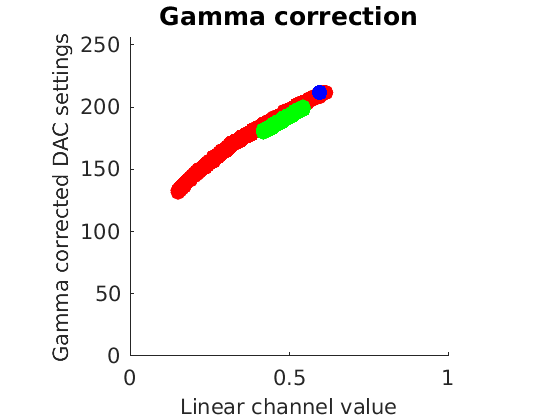

In [37]:
%% Gamma correct the primary values, so we can pop them into an isetbio
% scene in some straightforward manner.
%
% The plot should look compressive, because monitor gammas are expansive.
nLevels = size(displayGet(display,'gamma'),1);
gaborRGB = round(ieLUTLinear(gaborPrimary,displayGet(display,'inverse gamma')));
vcNewGraphWin; hold on
set(gca,'FontSize',10);
theColors = ['r' 'g' 'b'];
for ii = 1:3
    tempPrimary = gaborPrimary(:,:,ii);
    tempRGB = gaborRGB(:,:,ii);
    plot(tempPrimary(:),tempRGB(:),['o' theColors(ii)],'MarkerFaceColor',theColors(ii));
end
xlim([0 1]);
ylim([0 nLevels]);
axis('square');
xlabel('Linear channel value','FontSize',10);
ylabel('Gamma corrected DAC settings','FontSize',10);
title('Gamma correction','FontSize',12);

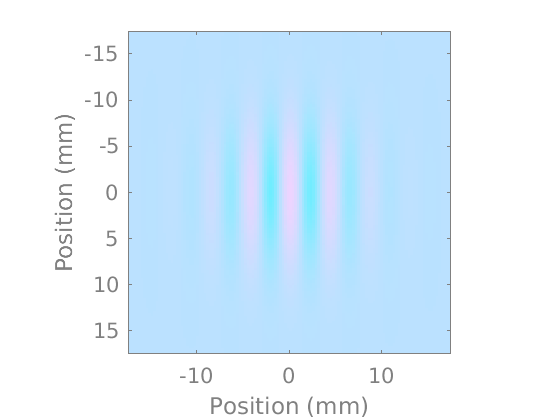

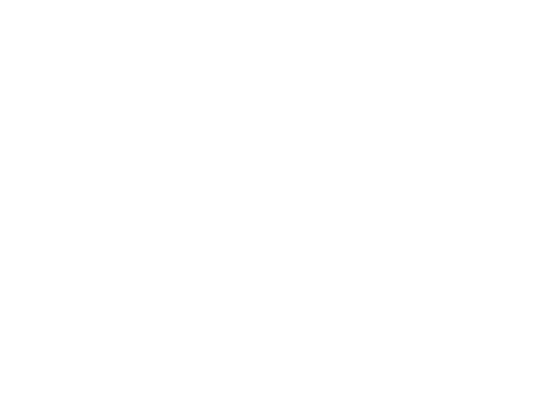

In [38]:
% Finally, make the actual isetbio scene
% This combines the image we build and the display properties.
gaborScene = sceneFromFile(gaborRGB,'rgb',[],display);
gaborScene = sceneSet(gaborScene, 'h fov', fieldOfViewDegs);

% Look at the scene image.  It is plausible for an L-M grating.  Remember that we
% are looking at the stimuli on a monitor different from the display file
% that we loaded, and thus the RGB values will not produce exactly the
% desired appearance.
vcNewGraphWin; scenePlot(gaborScene,'radiance image no grid');

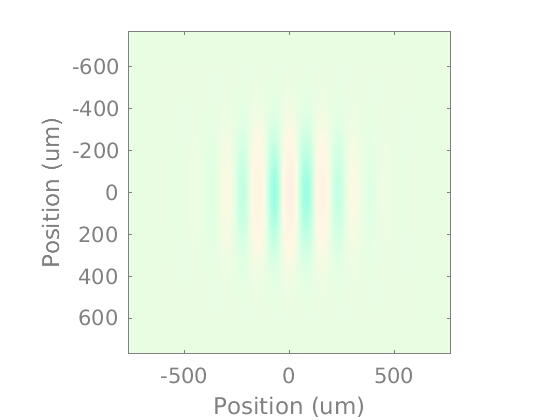

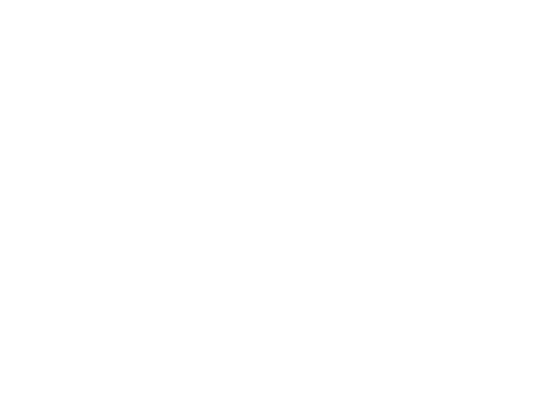

In [39]:
%% Create no optics oi
% Create an optical image with no optics.  Here our goal is to verify that
% the cone contrast we compute from actual absorptions matches what we
% specified at the start, so that we are confident we've produced the right
% stimulus scene.  So we don't want to get confused by the optics.
gaborOI = oiCreate('human');
gaborOI = oiSet(gaborOI,'h fov',fieldOfViewDegs);

% Turn off optics for current purpose of checking LMS contrast 
% This involves turning off the off-axis falloff in intensity and
% replacing the OTF with a unity OTF.
optics = oiGet(gaborOI,'optics');
optics = opticsSet(optics,'off axis method','skip');
optics = opticsSet(optics,'OTF',ones(size(opticsGet(optics,'OTF'))));
gaborOI= oiSet(gaborOI,'optics',optics);

% Look at the OI
% Note how different the color appearance is than the scene.  This is
% because the OI incorprates the transmittance of the lens.  Down below we
% will turn that off as a check.
gaborOI = oiCompute(gaborOI,gaborScene);
vcNewGraphWin; oiPlot(gaborOI,'irradiance image no grid');

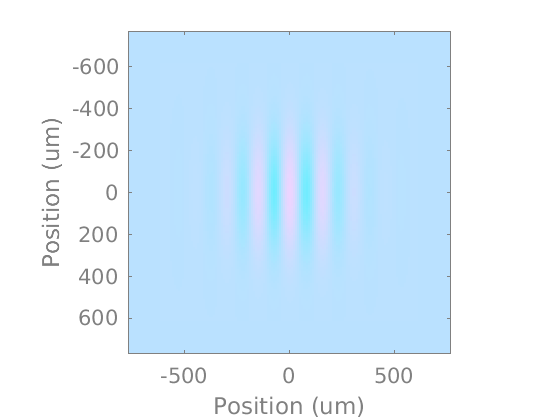

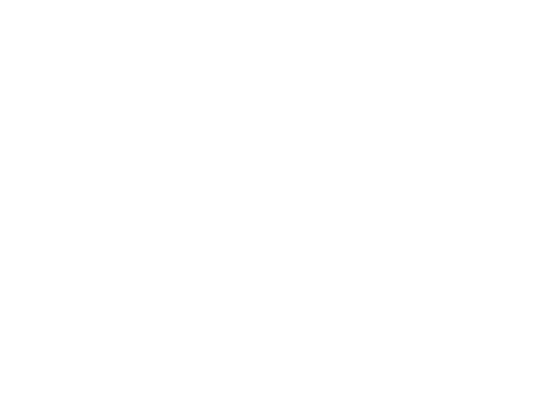

In [40]:
%% Verify that removing lens transmittance has expected effect
lens = oiGet(gaborOI,'lens');
lens.density = 0;
gaborOINoLens = oiSet(gaborOI,'lens',lens);
gaborOINoLens = oiCompute(gaborOINoLens,gaborScene);
vcNewGraphWin; oiPlot(gaborOINoLens,'irradiance image no grid');

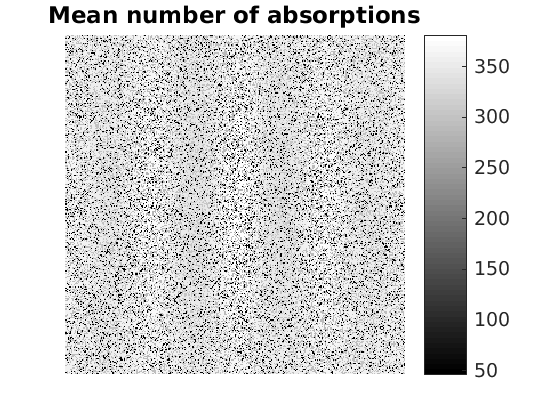

In [41]:
%% Create and get noise free sensor using coneMosaic obj
% Create a coneMosaic object here. When setting the fov, if only one value
% is specified, it will automatically make a square cone mosaic.  We don't
% need the whole field of view to check the contrast, which will be
% determined near the center of the Gabor, and making it smaller speeds
% things up.
gaborConeMosaic = coneMosaic;
gaborConeMosaic.setSizeToFOV(fieldOfViewDegs/2);

% There is also an option of whether the cone current should be calculated
% in the compute function. If set to true, it uses an os object inside the
% coneMosaic object. The default is the linearOS.  Here we don't need that.
gaborConeMosaic.noiseFlag = false;
photons = gaborConeMosaic.compute(gaborOI,'currentFlag',false);

% Take a look at the mosaic responses
%
% The pattern is pretty subtle, because the contrast seen by each
% class of cones is small.  Human vision is *very* sensitive to L-M
% modulations, so the pattern is much more salient when viewed as a 
% color image.
gaborConeMosaic.plot('mean absorptions');

In [42]:
%% Get min max for LMS cone absorptions
% Extract the min and max absorptions in a loop. Since we are
% extracting only L, M, or S absorptions at each iteration, we get a vector
% so one call to max/min will suffice.
conePattern = gaborConeMosaic.pattern;
for ii = 2:4
    maxAbsorption = max(photons(conePattern==ii));
    minAbsorption = min(photons(conePattern==ii));
    
    fprintf('%s cone absorptions\n\tMax: %d \n\tMin: %d\n',coneTypes{ii-1},maxAbsorption,minAbsorption);
    fprintf('\tAbsolute contrast: %04.3f\n',(maxAbsorption-minAbsorption)/(maxAbsorption+minAbsorption));
end


L cone absorptions
	Max: 3.806267e+02 
	Min: 3.439503e+02
	Absolute contrast: 0.051
M cone absorptions
	Max: 3.099491e+02 
	Min: 2.802653e+02
	Absolute contrast: 0.050
S cone absorptions
	Max: 4.650712e+01 
	Min: 4.633135e+01
	Absolute contrast: 0.002
